<a href="https://colab.research.google.com/github/johnjoel2001/ML_Explainability_I/blob/main/Explainable_Techniques_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XAI - AIPI 590**

**Assignment 03 - Explainable Techniques I**

**John Rohit Ernest Jayaraj**

In [20]:
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "ML_Explainability_I" # Change to your repo name
git_path = 'https://github.com/johnjoel2001/ML_Explainability_I.git' #Change to your path
!git clone "{git_path}"

Cloning into 'ML_Explainability_I'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


# **Local Explanations of ResNet34 model using LIME**

This notebook demonstrates local explanations for predictions from a pre-trained **ResNet34** model using **LIME ( Local Interpretable Model Explanations )**

The objective is to find out which parts of an image contribute the most to the model's classification decision.

# **1. Model Selection**

*   We will use ResNet34, one of the most popular CNN architecture used for image classification tasks.

*   It is a black-box model because it predicts without giving any explanation why certain features contribute to a particular decision.

*   ResNet34 is pre-trained on ImageNet, a large scale annotated dataset containing over 14 million images across 1,000 object categories.



# **2. Explanation Technique: LIME**

**Why LIME?**

LIME is well-suited for this task because:

*   **Model-Agnostic** - It can explain any model whcih includes deep learning models such as ResNet, Inception, YOLO etc
*   **Local Interpretability** - it is a local explanation, focused on one prediction at a time; assisting in debugging decisions independently.
* **Intuitive Visualization** - It highlights the image regions that were that were most influential for classification.



# **3. Code Implementation**

In [1]:
# Installing LIME
! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ac8914eaa48e98d528e3a2934a21f4e239e31f80ab1ae44a0157795837367ee1
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [14]:
# Importing torch and various dependencies

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import lime
import requests
from io import BytesIO
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic, mark_boundaries

In [3]:
# Downloading an image from Substack

def download_image(url):
    response = requests.get(url)
    if response.status_code == 200:
      return Image.open(BytesIO(response.content))
    else:
      print("Failed to download image")
      return None

In [4]:
# Providing Substack Image URL

image_url = "https://images.unsplash.com/photo-1549317661-bd32c8ce0db2?q=80&w=1470&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"  # Unsplash image URL
image = download_image(image_url)

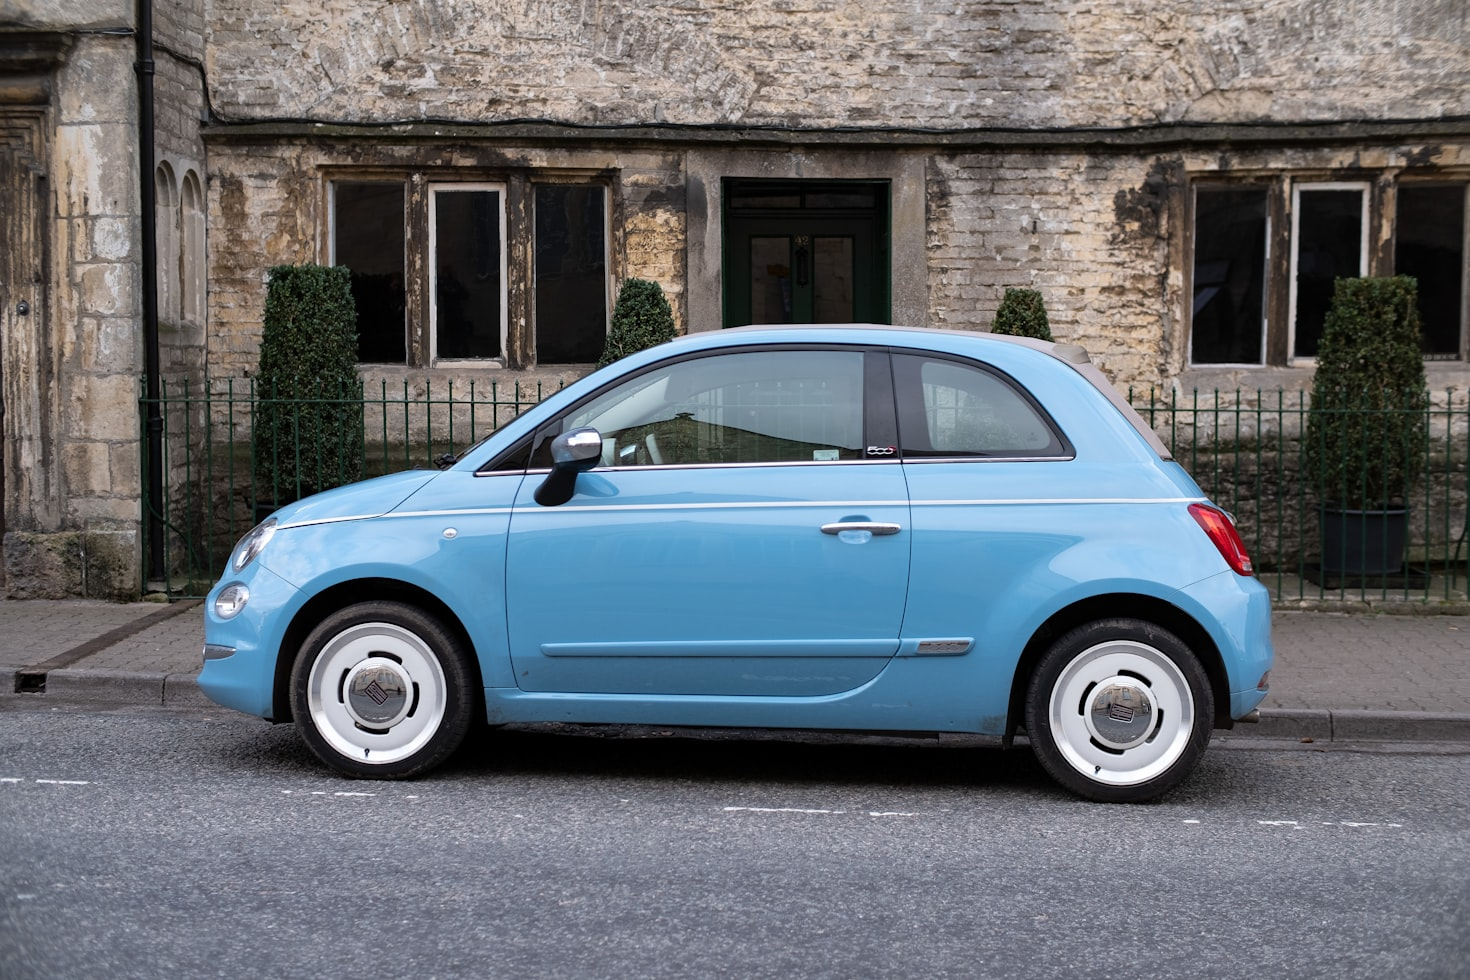

In [5]:
image # Displaying the image

In [6]:
# Loading Pre-Trained Resnet34 Model

model = models.resnet34(pretrained=True)
model.eval()

# Loading Imagenet class labels

LABELS_URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
labels=requests.get(LABELS_URL).json()
imagenet_labels = {int(key):value for key, value in labels.items()}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 73.1MB/s]


In [7]:
# Pre-processing the Image

pre_process = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor=pre_process(image).unsqueeze(0)

In [8]:
# Performing Image Predictions with ResNet34

with torch.no_grad():
    output = model(input_tensor)

# Converting to Probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Getting Top 5 Predictions
top5_pred, top5_catid =  torch.topk(probabilities,5)

print ("\n Top 5 Predictions") # Printing the top 5 predictions

top_5_predictions=[]

for i in range(5):
  predicted_class=imagenet_labels[top5_catid[i].item()]
  confidence_score=top5_pred[i].item()
  top_5_predictions.append((predicted_class, confidence_score))
  print(f"{i+1}. {predicted_class[1]}: {confidence_score:.3f}")


 Top 5 Predictions
1. minivan: 0.811
2. beach_wagon: 0.044
3. car_wheel: 0.040
4. parking_meter: 0.018
5. pickup: 0.010


**Inferences**

*   The model is most confident that the image is of a minivan with a confidence score of 81.1%.

*   The other predictions pertain to alternative car related objects.

*   We can witness here that sometimes deep learning models gets confused with similar features.



In [9]:
# Defining Prediction Function for LIME

def batch_predict (images):

  inputs=torch.stack([pre_process(Image.fromarray(img)) for img in images],dim=0)
  with torch.no_grad():
    outputs=model(inputs)
    return torch.nn.functional.softmax(outputs,dim=1).numpy()

In [15]:
# Applying LIME for Explainability for Top 5 Predictions

explainer=lime_image.LimeImageExplainer()
explanation=explainer.explain_instance(
    np.array(image),
    batch_predict,
    top_labels=5,   # Getting Explanations for top 5 Predictions
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda img: slic(img, n_segments=150, compactness=10, sigma=1)
)


  0%|          | 0/1000 [00:00<?, ?it/s]

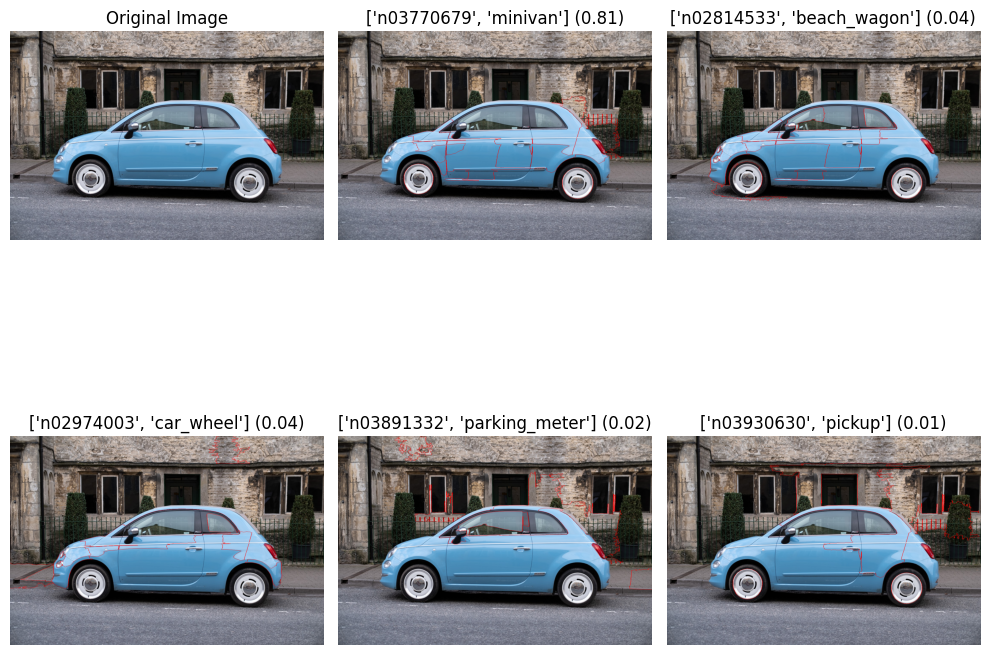

In [19]:
# Visualizing LIME Explanation for Top 5 Predictions

plt.figure(figsize=(10,10))

# Original Image

plt.subplot(2,3,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')


# Plotting LIME Explanations for each of the top 5 predictions

for i in range(5):
  top_label=top5_catid[i].item()
  temp, mask = explanation.get_image_and_mask(
      label=top_label,
      positive_only=True,
      num_features=10,
      hide_rest=False
  )

  plt.subplot(2,3,i+2)
  plt.imshow(mark_boundaries(temp/255.0, mask,color=(1, 0, 0)))
  plt.title(f"{top_5_predictions[i][0]} ({top_5_predictions[i][1]:.2f})")
  plt.axis('off')

plt.tight_layout()
plt.show()


# **Explainability of Our Model**

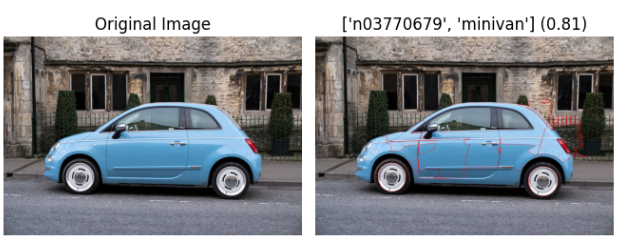

**Right Image (LIME Explainability)**

*   The model predicted this car as a "minivan" with a 81% confidence.

*   The red colour outlines the most important regions that influenced the model to classify it as a "minivan".

*   We can see that the model focused on the car's body structure, the windows and doors which resemble as of a minivan, the wheel area which possibly the model has mistaken it for minivan like properties (maybe the size of wheel)


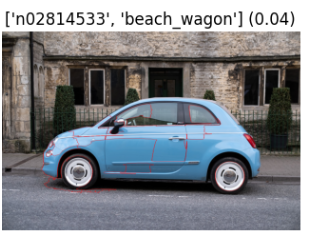

**LIME Explainability**

*   The model predicted the car as a "beach wagon" with a 4% confidence.

*   Red-marked areas indicate the most important regions that influenced the model's decision.

*   The model's focus show that:  the car’s side paneling, roofline, and wheels were major contributors.

*  Some background areas (windows and parts of the wall) also may have influenced the decision.




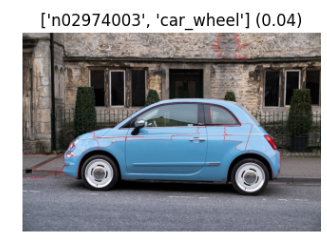

**LIME Explainability**

*   The model predicted the image as a "car wheel" with 4% confidence.

*   Red-marked areas indicate the most important regions that influenced the model's decision.

*   The model's focus was on: The wheels of the car and the lower portions of some parts of the body, near the wheels.

*    The background elements include the window, parts of the building, and road, suggesting that the model got slightly distracted by non-car elements.




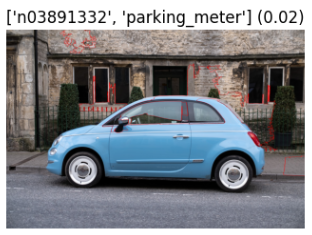

**LIME Explainability**

*   The model predicted the image as a "parking meter" with 2% confidence.

*   Red-marked areas indicate the most important regions that influenced the model's decision.

*   The model's focus shows: Parts of the window and the car's roofline were significant.

*   Background areas were also heavily factored in, such as the windows and parts of the wall.

*   It is obvious that the model was misled by background shapes and reflections rather than focusing solely on the car.





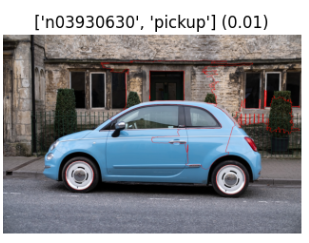

**LIME Explainability**

*   The model predicted the car as a "pickup truck" with only 1% confidence.

*   Red-marked areas indicate the most important regions that influenced the model's decision.

*   The model's focus show that: major factors in the decision were the wheels and body frame.

*   The background here has influenced the model classification: windows, bushes, and stone wall, which hints at some noise in the model's attention.

*   The car door and shape might have slightly resembled a pickup truck's features, which might have caused a weak misclassification.




# **Strengths of LIME**

*   **Helps Understand Misclassification** - We saw that" the car was mistaken for a "minivan", "beach wagon", "pickup", and "parking meter". LIME showed that the model relied more on the roof shape, wheel, and windows rather than the full car body or its structure.


*   **Visualises Feature Importance** - We saw that the roofline and doors were critical for the "minivan" prediction. The wheels played a major role in the "car wheel" prediction. Background elements such as windows and bushes misled a few incorrect predictions.

*  **Works on any Model** - As LIME is Model-Agnostic, it can be used on any Machine Learning or Deep Learning Model including transformers.



# **Limitations of LIME**

*   **Image Segmentation can be Inaccurate** - LIME relies on superpixel segmentation, which, at times, may include the background in explanations. This happened in the "parking meter" misclassification, where the model was focusing on the windows and wall textures rather than the car.

*   **Results can be Inconsistent** - Since LIME works by perturbing the image randomly, if we run it multiple times, it may give different feature highlights.
This may lead to unstable explanations, especially for low-confidence predictions such as "pickup" (1%).

*   **Computationally Expensive** - Since LIME makes multiple predictions on pertubed data points to highlight feature importance, it is considered to be computationally expensive.


# **Potential Improvements**

*   **Expand Training Data** - We can add more car images from different angles, lighting conditions, and backgrounds to improve model recognition and feature approximation.

*   **Increasing the Number of Perturbations** - We can increase `num_samples` (probably 5000 in place of 1000) for more stable explanations.

*  **Reduce Background Influence** - We can try preprocessing images by masking non-object areas using edge detection or cropping around the object.


# **Final Thoughts**

* LIME gave us very good insights as to how the ResNet34 model made its predictions, revealing that the model sometimes focused on the wrong features ( e.g the elements in the background and bits and pieces of car features )

* While LIME is a powerful tool for explaining deep learning models, we can try it out by combining it with other techniques like SHAP and Anchors to improve reliability, feature approximation and reduce inconsistencies.

# **References**

1)  **Unsplash Image URL ( I have selected this particular image for this Assignemnt )** - https://images.unsplash.com/photo-1549317661-bd32c8ce0db2?q=80&w=1470&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D

2) **ImageNet Class Labels** - https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"